In [ ]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [ ]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [3]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Deepchem\\")

In [4]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [5]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [6]:
#Reading the data
ML_data= pd.read_csv("./Original_data/ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./Original_data/X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original_data/Original_data.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(6313, 2851)


,MW,AMW,Sp,Si,Mp,Mi,GD,nAT,nSK,nAA,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
mol_id,,,,,,,,,,,,,,,,,,,,,
TOX1002,181.17,9.058500,12.9034,22.9535,0.645170,1.147675,0.166667,20.0,13.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOX10047,643.56,27.980870,24.3753,24.3350,1.059796,1.058043,0.116959,23.0,19.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOX10056,485.78,21.120870,21.6707,24.6518,0.942204,1.071817,0.132353,23.0,17.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOX1006,103.10,8.591667,6.6875,14.3289,0.557292,1.194075,0.285714,12.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOX10060,112.99,10.271818,7.7614,12.5488,0.705582,1.140800,0.400000,11.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
Raw_data

,smiles,Tox,Canonical_smiles
mol_id,,,
TOX1002,CN(N=O)c1ccc([N+](=O)[O-])cc1,1.0,CN(N=O)c1ccc([N+](=O)[O-])cc1
TOX10047,Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)cc1Br,0.0,Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)cc1Br
TOX10056,Brc1ccc(Oc2ccc(Br)cc2Br)c(Br)c1,1.0,Brc1ccc(Oc2ccc(Br)cc2Br)c(Br)c1
TOX1006,CN(N=O)C(N)=O,1.0,CN(N=O)C(N)=O
TOX10060,CC(C)(Cl)Cl,0.0,CC(C)(Cl)Cl
...,...,...,...
TOX9869,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,1.0,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O
TOX9874,CC(C)OC(=O)C(C)(C)Oc1ccc(C(=O)c2ccc(Cl)cc2)cc1,0.0,CC(C)OC(=O)C(C)(C)Oc1ccc(C(=O)c2ccc(Cl)cc2)cc1
TOX9879,CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4c...,1.0,CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4c...


In [8]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(6313, 148)


,piID,GATS1i,C%,P_VSA_p_3,LOGP99,SpMax1_Bh(p),Mi,Mp,P_VSA_charge_7,MCD,...,T(Cl..Cl),nRNR2,B05[N-N],nArNO2,s4_relPathLength_2,MATS3p,F07[C-F],CATS2D_06_DD,nArNH2,nRCO
mol_id,,,,,,,,,,,,,,,,,,,,,
TOX1002,0.281159,0.311425,0.540909,0.110295,0.694847,0.064816,0.741584,0.009558,0.098051,0.461538,...,0.000000,0.0,1.0,0.333333,0.0,0.569797,0.0,0.0,0.0,0.0
TOX10047,0.361336,0.234617,0.806324,0.728946,0.781982,0.069173,0.644531,0.028300,0.811282,0.631579,...,0.000000,0.0,0.0,0.000000,0.0,0.596653,0.0,0.0,0.0,0.0
TOX10056,0.351116,0.240915,0.806324,0.560643,0.759144,0.067881,0.659446,0.022984,0.384820,0.705882,...,0.000000,0.0,0.0,0.000000,0.0,0.567061,0.0,0.0,0.0,0.0
TOX1006,0.159590,0.609880,0.257576,0.026975,0.656549,0.038729,0.791826,0.005586,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.475521,0.0,0.0,0.0,0.0
TOX10060,0.118383,0.503088,0.421488,0.204238,0.694316,0.050068,0.734140,0.012289,0.045657,0.000000,...,0.007634,0.0,0.0,0.000000,0.0,0.210090,0.0,0.0,0.0,0.0


In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Tox'].values
clf=DecisionTreeClassifier(random_state=0)

# DT

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.682749,0.001541
Accuracy_train,0.996934,0.000031
F1 Score,0.514797,0.002485
Precision,0.507719,0.002346
Recall,0.522909,0.003383
Roc_auc,0.641574,0.001774


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.674595,0.001878
Accuracy_train,0.996934,0.000031
F1 Score,0.502903,0.002742
Precision,0.495664,0.002827
Recall,0.511125,0.003318
Roc_auc,0.632679,0.001994


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-05-31 23:33:03,147] A new study created in memory with name: no-name-aae9a032-ff42-4727-b3cb-858430713be5
[I 2023-05-31 23:33:04,965] Trial 0 finished with value: 0.717185901422295 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.717185901422295.
[I 2023-05-31 23:33:05,345] Trial 1 finished with value: 0.7198163202872672 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 1 with value: 0.7198163202872672.
[I 2023-05-31 23:33:05,741] Trial 2 finished with value: 0.7178189381933435 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 1 with value: 0.7198163202872672.
[I 2023-05-31 23:33:06,152] Trial 3 finished with value: 0.7165696653894759 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 1 with value: 0.7198163202872672.
[I 2023-05-31 23:33:06,593] Trial 4 finished with value: 0.7228733525246241 

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 3, 'max_features': 13, 'min_samples_split': 7}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.726596,0.001268
Accuracy_train,0.730461,0.000204
F1 Score,0.475011,0.003026
Precision,0.622935,0.003191
Recall,0.384717,0.003244
Roc_auc,0.695858,0.002053


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [17]:
data_dt=ML_data[columns]
data_dt.to_csv("./Results/data_dt.csv",sep=',')
X_DT=np.array(data_dt)

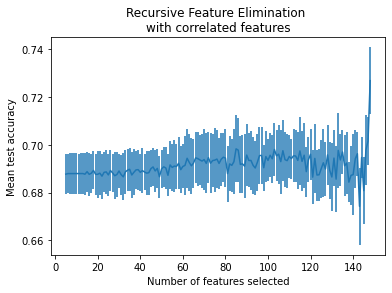

In [18]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [19]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.726596,0.001268
Accuracy_train,0.730461,0.000204
F1 Score,0.475011,0.003026
Precision,0.622935,0.003191
Recall,0.384717,0.003244
Roc_auc,0.695858,0.002053


In [20]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/DT.pkl')
DT= joblib.load(filename='./Models/DT.pkl')

In [21]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original_data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_dt.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,piID,GATS1i,C%,P_VSA_p_3,LOGP99,SpMax1_Bh(p),Mi,Mp,P_VSA_charge_7,MCD,...,T(Cl..Cl),nRNR2,B05[N-N],nArNO2,s4_relPathLength_2,MATS3p,F07[C-F],CATS2D_06_DD,nArNH2,nRCO
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.353850,0.498805,0.515152,0.070428,0.656196,0.068036,0.748277,0.009103,0.006556,0.933333,...,0.0,0.00,0.0,0.0,0.333333,0.622930,0.0,0.0,0.25,0.0
13463,0.374116,0.486588,0.498534,0.139261,0.650382,0.066930,0.746704,0.009989,0.000000,0.736842,...,0.0,0.00,0.0,0.0,0.353632,0.626534,0.0,0.0,0.25,0.0
39148,0.381559,0.547484,0.475524,0.085608,0.640241,0.067085,0.751298,0.008172,0.043439,0.666667,...,0.0,0.25,0.0,0.0,0.353632,0.610802,0.0,0.0,0.25,0.0
56328,0.369855,0.415277,0.515152,0.059896,0.661763,0.066923,0.758929,0.008903,0.000000,0.777778,...,0.0,0.00,0.0,0.0,0.351852,0.659481,0.0,0.0,0.25,0.0
67358,0.378431,0.487664,0.468320,0.049862,0.620309,0.068155,0.752282,0.008265,0.000000,0.700000,...,0.0,0.00,0.0,0.0,0.325758,0.632982,0.0,0.0,0.25,0.0


In [22]:
#Predicted results
Predicted_data=pd.DataFrame(DT.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/DT_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of nonactivity,Probability of activity
cid,,
12777818,0.368078,0.631922
511720,0.368078,0.631922
10041866,0.368078,0.631922
5273008,0.368078,0.631922
5273004,0.368078,0.631922


In [23]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.682749  0.001541  0.674595  0.001878  0.726596  0.001268   
Accuracy_train     0.996934  0.000031  0.996934  0.000031  0.730461  0.000204   
F1 Score           0.514797  0.002485  0.502903  0.002742  0.475011  0.003026   
Precision          0.507719  0.002346  0.495664  0.002827  0.622935  0.003191   
Recall             0.522909  0.003383  0.511125  0.003318  0.384717  0.003244   
Roc_auc            0.641574  0.001774  0.632679  0.001994  0.695858  0.002053   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.726596  0.001268  
Accuracy_train  0.730461  0.000204  
F1 Score        0.475011  0.003026  
Precision       0.622935  0.003191  
Recall          0.384717  0.003244  
Roc_auc         0.695858  0.002053

# LR

In [11]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.726120,0.002064
Accuracy_train,0.734942,0.001924
F1 Score,0.414944,0.008511
Precision,0.657432,0.005621
Recall,0.309067,0.008209
Roc_auc,0.718693,0.003241


In [12]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.748440,0.001313
Accuracy_train,0.758472,0.000221
F1 Score,0.503939,0.003068
Precision,0.691310,0.003635
Recall,0.397348,0.003180
Roc_auc,0.741981,0.002042


In [13]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-06-01 00:16:40,272] A new study created in memory with name: no-name-6a9d7542-d350-438a-8412-62e75841d0d3
[I 2023-06-01 00:16:44,727] Trial 0 finished with value: 0.7461743465265102 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.7461743465265102.
[I 2023-06-01 00:16:46,716] Trial 1 finished with value: 0.7336125599309912 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.7461743465265102.
[I 2023-06-01 00:16:48,220] Trial 2 finished with value: 0.7130365202912793 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.7461743465265102.
[I 2023-06-01 00:16:55,716] Trial 3 finished with value: 0.7486615328291443 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 3 with value: 0.748661532

In [14]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 3.1460009033362937, 'l1_ratio': 0.7171792821986983, 'max_iter': 510}


In [15]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.749343,0.001279
Accuracy_train,0.762170,0.000243
F1 Score,0.514410,0.003027
Precision,0.684745,0.003414
Recall,0.412981,0.003343
Roc_auc,0.743257,0.002066


In [16]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [17]:
data_lr=ML_data[columns]
data_lr.to_csv("./Results/data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [18]:
data_lr

,piID,GATS1i,C%,P_VSA_p_3,LOGP99,SpMax1_Bh(p),Mi,Mp,P_VSA_charge_7,MCD,...,CATS2D_07_AA,T(Cl..Cl),nRNR2,B05[N-N],nArNO2,s4_relPathLength_2,F07[C-F],CATS2D_06_DD,nArNH2,nRCO
mol_id,,,,,,,,,,,,,,,,,,,,,
TOX1002,0.281159,0.311425,0.540909,0.110295,0.694847,0.064816,0.741584,0.009558,0.098051,0.461538,...,0.029703,0.000000,0.0,1.0,0.333333,0.000000,0.000000,0.0,0.0,0.0
TOX10047,0.361336,0.234617,0.806324,0.728946,0.781982,0.069173,0.644531,0.028300,0.811282,0.631579,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
TOX10056,0.351116,0.240915,0.806324,0.560643,0.759144,0.067881,0.659446,0.022984,0.384820,0.705882,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
TOX1006,0.159590,0.609880,0.257576,0.026975,0.656549,0.038729,0.791826,0.005586,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
TOX10060,0.118383,0.503088,0.421488,0.204238,0.694316,0.050068,0.734140,0.012289,0.045657,0.000000,...,0.000000,0.007634,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOX9869,0.371412,0.333516,0.652525,0.336280,0.714599,0.066421,0.712385,0.010827,0.207530,0.480000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
TOX9874,0.376317,0.338373,0.671937,0.378258,0.731455,0.068322,0.707588,0.010908,0.287416,0.480000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
TOX9879,0.445144,0.447136,0.627841,0.474207,0.724353,0.067759,0.719001,0.011086,0.147076,0.777778,...,0.000000,0.015267,0.0,0.0,0.000000,0.480908,0.000000,0.0,0.0,0.0


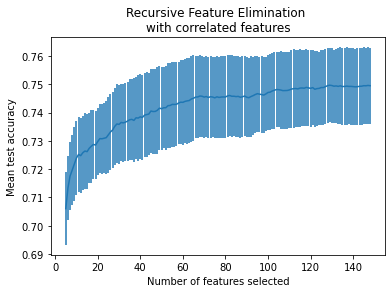

In [19]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [20]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.750769,0.001306
Accuracy_train,0.762502,0.000251
F1 Score,0.516678,0.003114
Precision,0.688768,0.003429
Recall,0.414407,0.003401
Roc_auc,0.746089,0.002104


In [21]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/LogReg.pkl')
LogReg= joblib.load(filename='./Models/LogReg.pkl')

In [23]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original_data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_lr.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,piID,GATS1i,C%,P_VSA_p_3,LOGP99,SpMax1_Bh(p),Mi,Mp,P_VSA_charge_7,MCD,...,CATS2D_07_AA,T(Cl..Cl),nRNR2,B05[N-N],nArNO2,s4_relPathLength_2,F07[C-F],CATS2D_06_DD,nArNH2,nRCO
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.353850,0.498805,0.515152,0.070428,0.656196,0.068036,0.748277,0.009103,0.006556,0.933333,...,0.000000,0.0,0.00,0.0,0.0,0.333333,0.0,0.0,0.25,0.0
13463,0.374116,0.486588,0.498534,0.139261,0.650382,0.066930,0.746704,0.009989,0.000000,0.736842,...,0.009901,0.0,0.00,0.0,0.0,0.353632,0.0,0.0,0.25,0.0
39148,0.381559,0.547484,0.475524,0.085608,0.640241,0.067085,0.751298,0.008172,0.043439,0.666667,...,0.029703,0.0,0.25,0.0,0.0,0.353632,0.0,0.0,0.25,0.0
56328,0.369855,0.415277,0.515152,0.059896,0.661763,0.066923,0.758929,0.008903,0.000000,0.777778,...,0.019802,0.0,0.00,0.0,0.0,0.351852,0.0,0.0,0.25,0.0
67358,0.378431,0.487664,0.468320,0.049862,0.620309,0.068155,0.752282,0.008265,0.000000,0.700000,...,0.039604,0.0,0.00,0.0,0.0,0.325758,0.0,0.0,0.25,0.0


In [25]:
#Predicted results
Predicted_data=pd.DataFrame(LogReg.predict_proba(X_test),columns=['Probability of nontox','Probability of tox'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of tox" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/LR_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of nontox,Probability of tox
cid,,
5273004,0.121084,0.878916
14258187,0.144009,0.855991
121486770,0.159208,0.840792
6454537,0.161512,0.838488
54192124,0.161512,0.838488


In [26]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.726120  0.002064  0.748440  0.001313  0.749343   
Accuracy_train           0.734942  0.001924  0.758472  0.000221  0.762170   
F1 Score                 0.414944  0.008511  0.503939  0.003068  0.514410   
Precision                0.657432  0.005621  0.691310  0.003635  0.684745   
Recall                   0.309067  0.008209  0.397348  0.003180  0.412981   
Roc_auc                  0.718693  0.003241  0.741981  0.002042  0.743257   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.001279  0.750769  0.001306  
Accuracy_train  0.000243  0.762502  0.000251  
F1 Score        0.003027  0.516678  0.003114  
Precision       0.003414  0.688768  0.003429  
Recall          0.003343  0.414407  0.003401  
Roc_auc         0.002066  0.746089  0.002104

# RF

In [18]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.764914,0.001528
Accuracy_train,0.996901,0.000032
F1 Score,0.558826,0.003486
Precision,0.706132,0.003361
Recall,0.463278,0.003834
Roc_auc,0.776014,0.001889


In [19]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.765325,0.001429
Accuracy_train,0.996913,0.000032
F1 Score,0.555456,0.003214
Precision,0.712967,0.003606
Recall,0.456048,0.003588
Roc_auc,0.776483,0.001923


In [20]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-06-01 02:50:27,885] A new study created in memory with name: no-name-83b62b7d-a2ff-4b90-8dfe-ac4b903938fe
[I 2023-06-01 02:50:48,585] Trial 0 finished with value: 0.6778079800999015 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.6778079800999015.
[I 2023-06-01 02:51:02,864] Trial 1 finished with value: 0.6778079800999015 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.6778079800999015.
[I 2023-06-01 02:51:36,818] Trial 2 finished with value: 0.6778079800999015 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.6778079800999015.
[I 2023-06-01 02:51:51,410] Trial 3 finished with value: 0.6778079800999015 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [21]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}


In [22]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.677808,0.000060
Accuracy_train,0.677808,0.000007
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [23]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [24]:
data_rf=ML_data[columns]
data_rf.to_csv("./Results/data_rf.csv",sep=',')
X_RF=np.array(data_rf)

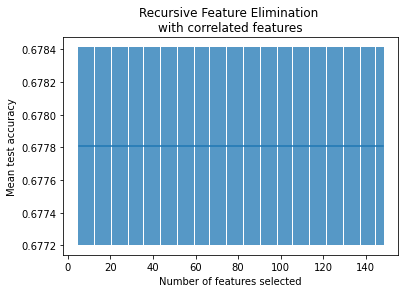

In [25]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [26]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.677808,0.000060
Accuracy_train,0.677808,0.000007
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [27]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/RF.pkl')
RF= joblib.load(filename='./Models/RF.pkl')

In [28]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original_data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_rf.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,MATS3p,F07[C-F],CATS2D_06_DD,nArNH2,nRCO
cid,,,,,
5273,0.622930,0.0,0.0,0.25,0.0
13463,0.626534,0.0,0.0,0.25,0.0
39148,0.610802,0.0,0.0,0.25,0.0
56328,0.659481,0.0,0.0,0.25,0.0
67358,0.632982,0.0,0.0,0.25,0.0


In [29]:
#Predicted results
Predicted_data=pd.DataFrame(RF.predict_proba(X_test),columns=['Probability of nontox','Probability of tox'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of tox" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/RF_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of nontox,Probability of tox
cid,,
5273,0.677238,0.322762
15954436,0.677238,0.322762
72264,0.677238,0.322762
72257,0.677238,0.322762
72251,0.677238,0.322762


In [30]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.764914  0.001528  0.765325  0.001429  0.677808  0.000060   
Accuracy_train     0.996901  0.000032  0.996913  0.000032  0.677808  0.000007   
F1 Score           0.558826  0.003486  0.555456  0.003214  0.000000  0.000000   
Precision          0.706132  0.003361  0.712967  0.003606  0.000000  0.000000   
Recall             0.463278  0.003834  0.456048  0.003588  0.000000  0.000000   
Roc_auc            0.776014  0.001889  0.776483  0.001923  0.500000  0.000000   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.677808  0.000060  
Accuracy_train  0.677808  0.000007  
F1 Score        0.000000  0.000000  
Precision       0.000000  0.000000  
Recall          0.000000  0.000000  
Roc_auc         0.500000  0.000000

# XGBoost

In [16]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.758831,0.001504
Accuracy_train,0.996181,0.000053
F1 Score,0.574467,0.003124
Precision,0.665613,0.003095
Recall,0.506292,0.003768
Roc_auc,0.759846,0.002046


In [17]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.757421,0.001604
Accuracy_train,0.995019,0.000090
F1 Score,0.569699,0.003185
Precision,0.664999,0.003391
Recall,0.499268,0.003690
Roc_auc,0.756386,0.002204


In [18]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-08-13 16:23:22,749] A new study created in memory with name: no-name-f90256a2-6fdc-4807-bafa-8d3a876ef2ea
[I 2023-08-13 16:26:24,068] Trial 0 finished with value: 0.7621268731569341 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.7621268731569341.
[I 2023-08-13 16:29:23,206] Trial 1 finished with value: 0.7581819093662863 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.7621268731569341.
[I 2023-08-13 16:30:55,321] Trial 2 finished with value: 0.7422939527372663 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 0 with value: 0.762

In [19]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 1.4287369509741588, 'alpha': 0.5133221798649492, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.9, 'learning_rate': 0.0101, 'n_estimators': 823}


In [20]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.770505,0.001324
Accuracy_train,0.927888,0.000191
F1 Score,0.571145,0.003004
Precision,0.717660,0.003171
Recall,0.475326,0.003517
Roc_auc,0.780635,0.001966


In [21]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [22]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./Results/data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

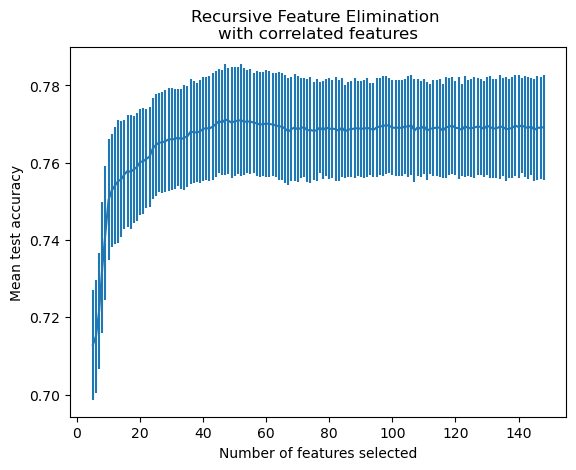

In [23]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [24]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.776540,0.001364
Accuracy_train,0.891290,0.000207
F1 Score,0.585852,0.003104
Precision,0.726766,0.003049
Recall,0.491648,0.003599
Roc_auc,0.784769,0.001985


In [25]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/XGB.pkl')
XGB= joblib.load(filename='./Models/XGB.pkl')

In [27]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original_data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,piID,GATS1i,P_VSA_p_3,LOGP99,Mp,P_VSA_charge_7,MATS1p,SpMax1_Bh(m),Fsp3,GATS1m,...,C-040,C-034,C-039,P_VSA_MR_8,CATS2D_00_NN,nRNR2,nArNO2,s4_relPathLength_2,nArNH2,nRCO
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.353850,0.498805,0.070428,0.656196,0.009103,0.006556,0.437915,0.198760,0.444444,0.219739,...,0.0,0.25,0.0,0.0,0.000000,0.00,0.0,0.333333,0.25,0.0
13463,0.374116,0.486588,0.139261,0.650382,0.009989,0.000000,0.496018,0.197599,0.500000,0.171174,...,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.353632,0.25,0.0
39148,0.381559,0.547484,0.085608,0.640241,0.008172,0.043439,0.432053,0.197491,0.583333,0.233417,...,0.0,0.00,0.0,0.0,0.000000,0.25,0.0,0.353632,0.25,0.0
56328,0.369855,0.415277,0.059896,0.661763,0.008903,0.000000,0.452906,0.197369,0.500000,0.197739,...,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.351852,0.25,0.0
67358,0.378431,0.487664,0.049862,0.620309,0.008265,0.000000,0.510588,0.199941,0.500000,0.213771,...,0.0,0.00,0.0,0.0,0.166667,0.00,0.0,0.325758,0.25,0.0


In [28]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of nontox','Probability of tox'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of tox" ,inplace=True, ascending=False)
Predicted_data.to_csv("./Results/XGB_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of nontox,Probability of tox
cid,,
5273008,0.181644,0.818356
5273004,0.198203,0.801797
250899,0.203479,0.796521
15926747,0.207072,0.792928
9882903,0.207072,0.792928


In [29]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.758831  0.001504  0.757421  0.001604  0.770505  0.001324   
Accuracy_train  0.996181  0.000053  0.995019  0.000090  0.927888  0.000191   
F1 Score        0.574467  0.003124  0.569699  0.003185  0.571145  0.003004   
Precision       0.665613  0.003095  0.664999  0.003391  0.717660  0.003171   
Recall          0.506292  0.003768  0.499268  0.003690  0.475326  0.003517   
Roc_auc         0.759846  0.002046  0.756386  0.002204  0.780635  0.001966   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.776540  0.001364  
Accuracy_train  0.891290  0.000207  
F1 Score        0.585852  0.003104  
Precision       0.726766  0.003049  
Recall          0.491648  0.003599  
Roc_auc         0.784769  0.001985